# HBV model BMI calibration exercise with ERA5 forcing and GRDC observation

In this notebook you will calibrate your own HBV model using ERA5 forcing data and GRDC observation data


For forcing we use the eWaterCycle generic forcing generator. This can generate forcing data with ESMValTool from ERA5 data (if available on your machine), as well as CMIP6 data (which will be downloaded automatically). 

Here we use ERA5 and compare it to the observations of the GRDC for the Rhine basin. In the first cell we load all required dependencies and set a few parameters for this experiment

In [1]:
#from leakybucket.leakybucket_bmi import LeakyBucketBmi
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print

from ewatercycle_wrapper_HBV import HBV
 
#shapefile that describes the basin we want to study.
shapeFile = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"

forcingLocation = Path("/home/rhut/forcingFiles/Rhine2000")

#GRDC station ID for the observation station
grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

#period of interest. Make sure that ERA5 is available on your machine for this period.
experiment_start_time="2000-01-01T00:00:00Z"
experiment_end_time="2000-12-31T00:00:00Z"


/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


Forcing is created using the GenericLumpedForcing in eWaterCycle. This selects rainfall and precipitation from the indicated dataset for the given time period and averages over the indicated shape. The result is two NetCDF files and a yaml file. This can later be loaded using ```GenericLumpedForcing.load()```. 

In [ ]:
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#     dataset="ERA5",
#     start_time=experiment_start_time,
#     end_time=experiment_end_time,
#     shape=shapeFile.absolute(),
# )


In [2]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-01-01T00:00:00Z',
    end_time='2000-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcingFiles/Rhine2000'),
    shape=PosixPath('/home/rhut/forcingFiles/Rhine2000/Rhine.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2000.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2000.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2000.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

Now we have the forcing data available we can prepare the configuration file:

In [3]:
s_0 = np.array([0,  100,  0,  5])
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
par_0 = (p_min_initial + p_max_initial)/2

In [4]:
model = HBV(forcing=ERA5_forcing)

In [6]:
type(model)

ewatercycle_wrapper_HBV.HBV

In [7]:
config_file, _ = model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                               )

In [20]:
model.initialize(config_file)

/home/rhut/repos/teaching-materials/teaching-files/hbv_bmi.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.


In [21]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    discharge_this_timestep = model.get_value("Q")
    Q_m.append(discharge_this_timestep[0])
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [22]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

With the configuration file ready, we can define the model and initialize it. To clearly indicate that we are creating an instance of the class ```LeakyBucketBMI``` we use ```experiment_model``` as the name for the model object for this (demo) experiment.

We can now use the `.update()` method to advance the model one time step.
After updating the model, we can request the current discharge using `.get_value("discharge")`.

We store this discharge in a list. For plotting, we also request the current model time (which is in seconds since 1970), and covert that to a pandas Timestamp.

We can plot the output discharge directly

AttributeError: 'HBV' object has no attribute 'get_var_units'

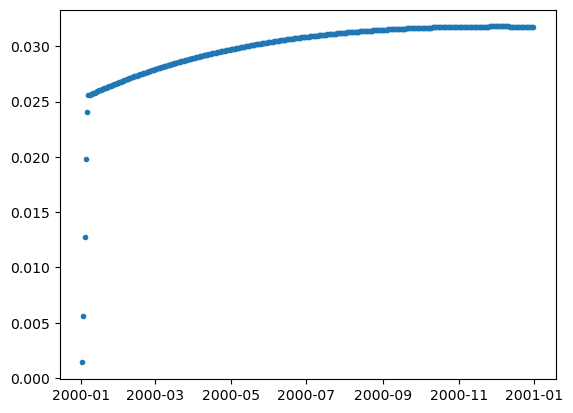

In [23]:
import matplotlib.pyplot as plt
plt.plot(time, Q_m,'.')

plt.ylabel(f"Discharge [{model.get_var_units('Q')}]")
plt.xlabel("Time")

But we can also use the ```hydrograph``` function from eWaterCycle. This will make a hydrograph that compares model output to observations. For this we need to load observations and make sure that the observations and model output are in the same units. Observations typically are in m3/s. 

Note that the unit of discharge from this model is in mm/d. Conversion to m3/s requires the area of the catchment.

In [24]:
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", shape_area)

The catchment area is: 163122500000.0

The hydrograph function requires dataFrames, so we put the discharge in a dataFrame and transform it to m3 per second 

In [25]:
discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))


In [26]:
discharge_dataframe['model output'] = discharge_dataframe['model output'] * shape_area / (1000 * 86400)

The observation data is loaded using ```the get_grdc_data()``` function build into eWaterCycle. The observation data and discharge data are combined together into one dataFrame. Note that we re-index the discharge data to make sure they are at the same timestamp.

In [27]:

observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=experiment_start_time,
    end_time=experiment_end_time,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

In [28]:
hydro_data = pd.concat([discharge_dataframe.reindex(grdc_obs.index, method = 'ffill'), grdc_obs], axis=1)
hydro_data

,model output,Observations from GRDC
time,,
2000-01-01,NaN,6010.0
2000-01-02,2.667414,5330.0
2000-01-03,10.675157,4700.0
2000-01-04,24.034203,4260.0
2000-01-05,37.420627,3980.0
...,...,...
2000-12-27,59.983183,1900.0
2000-12-28,59.980713,1940.0
2000-12-29,59.978148,2150.0


Finally plot the hydrograph. Of course the result of a simple leaky bucket model for the entire Rhine basin is a gross simplification, but it is illustrating to see that even such a simple model follows the shape of the observations. 

/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [0] contained NaN values and the row(s) have been removed (Rows are zero indexed).


(<Figure size 1000x1000 with 2 Axes>,
 (<Axes: title={'center': 'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <Axes: >))

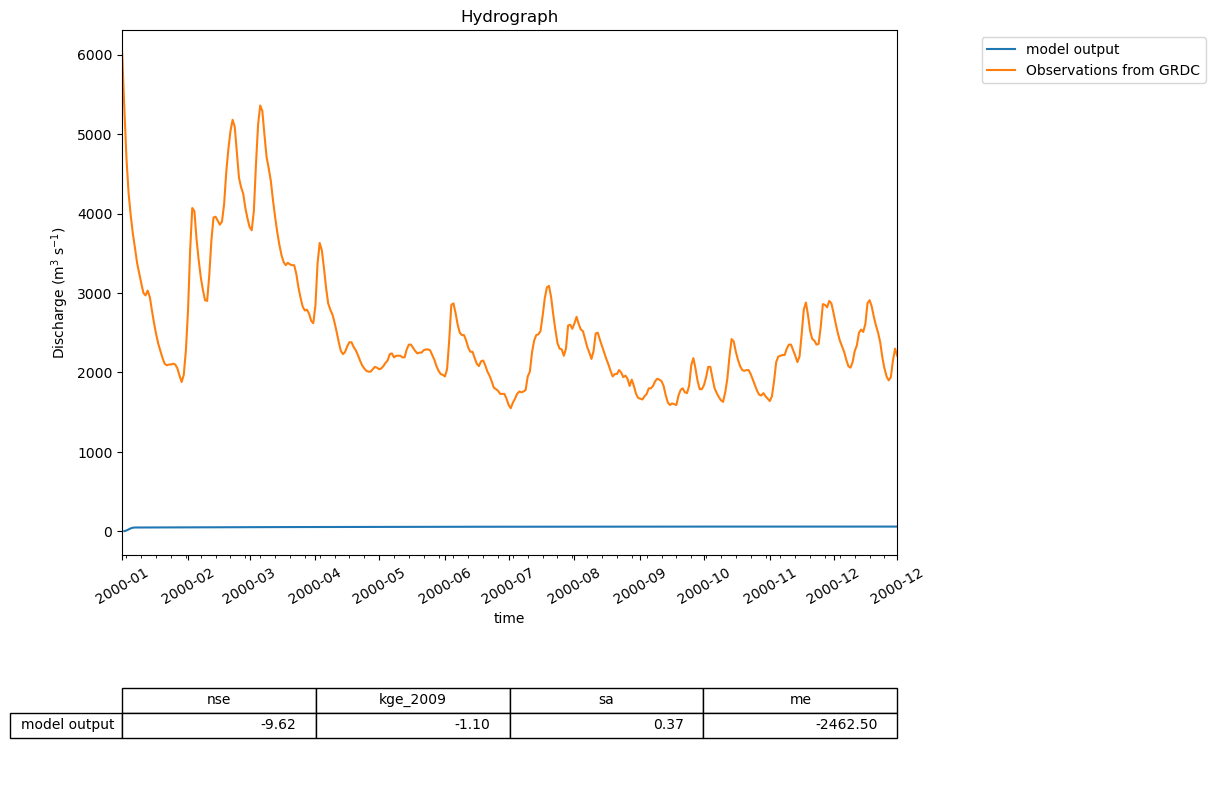

In [29]:
# Plot hydrograph and show metrics
ewatercycle.analysis.hydrograph(hydro_data, reference='Observations from GRDC', filename = 'experiment_hydrograph.png')

It is good practice to remove a model object when done using ```.finalize()```. For small models like this, it doesn't matter too much, but larger models that run in containers keep using resources when not ```finalized```.

In [31]:
model.finalize()

AttributeError: 'LumpedMakkinkForcing' object has no attribute 'camels_txt_defined'